In [1]:
!nvidia-smi

Thu Jan 28 14:58:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/SpirinEgor/HSE.machine_learning/main/06.%20This%20Cat%20Does%20Not%20Exist/cat_136.zip
!unzip -q cat_136.zip

--2021-01-28 13:21:08--  https://raw.githubusercontent.com/SpirinEgor/HSE.machine_learning/main/06.%20This%20Cat%20Does%20Not%20Exist/cat_136.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59645032 (57M) [application/zip]
Saving to: ‘cat_136.zip’

cat_136.zip         100%[===================>]  56.88M   286MB/s    in 0.2s    

2021-01-28 13:21:09 (286 MB/s) - ‘cat_136.zip’ saved [59645032/59645032]



# This cat does not exist
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW06] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

Цель этого задания - создать котов, которых не существует. В ходе данного задания вы обучите DCGAN и VAE, которые являются одними из первых генеративных моделей. Для этого задания вам наверняка потребуется GPU с CUDA, поэтому рекомендуется использовать Google Colab.

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

%matplotlib inline

In [3]:
SEED = 7
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

def imagewide_average(x):
    return x.mean(dim=(-1, -2))

In [5]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="cat_136", size=64):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:512 - crop_rate + x_crop, y_crop:512 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    def __len__(self):
        return len(self.photo_names)

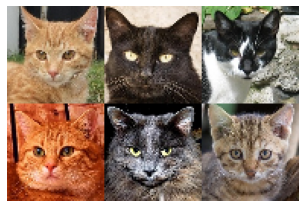

In [7]:
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 182, 592, 394, 2941]], dim=0))

### Задание 1 (2 балла)
Для начала реализуем генератор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](https://github.com/SpirinEgor/HSE.machine_learning/blob/main/06.%20This%20Cat%20Does%20Not%20Exist/imgs/DCGAN.png?raw=1)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ConvTranspose2D`, `nn.ReLU`, а также функция `F.interpolate`.

#### Методы
* `__init__` - принимает на вход `start_size`, `latent_channels`, `start_channels` и `upsamplings`. Первые два аргумента отвечают за размер случайного шума, из которого в последствии будет сгенерирована картинка. `start_channels` отвечает за то, сколько каналов должно быть в картинке перед тем, как к ней будут применены upsampling блоки. `upsamplings` - это количество upsampling блоков, которые должны быть применены к картинке. В каждом таком локе количество каналов уменьшается в два раза.


* `forward` - принимает на вход `batch_size`, генерирует `batch_size` картинок из случайного шума.

In [8]:
class Generator(nn.Module):
    def __init__(self, start_size=2, latent_channels=32, start_channels=1024, upsamplings=6):
        super().__init__()
        self._start_size = start_size
        self._latent_channels = latent_channels

        modules = [nn.Conv2d(latent_channels, start_channels, 1, 1, 0)]
        for _ in range(upsamplings):
            modules += [
                nn.ConvTranspose2d(start_channels, start_channels // 2, 4, 2, 1),
                nn.BatchNorm2d(start_channels // 2),
                nn.ReLU()
            ]
            start_channels //= 2
        modules += [nn.Conv2d(start_channels, 3, 1, 1, 0), nn.Tanh()]
        self._generator = nn.Sequential(*modules)
        
    
    def forward(self, batch_size: int):
        noise = random_noise(batch_size, self._latent_channels, self._start_size)
        # torch.Tensor batch_size x 3 x (start_size * 2**upsamplings) x (start_size * 2**upsamplings)
        return self._generator(noise)

### Задание 2 (2 балла)
Для начала реализуем дискриминатор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](https://github.com/SpirinEgor/HSE.machine_learning/blob/main/06.%20This%20Cat%20Does%20Not%20Exist/imgs/Disc_DCGAN.png?raw=1)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ReLU` и `nn.Sigmoid`.

#### Методы
* `__init__` - принимает на вход `start_channels` и `downsamplings`. `start_channels` определяет количество каналов, которые должны быть в изображении перед применением downsampling блоков.


* `forward` - принимает на вход `x` - тензор с картинками. Возвращает вектор с размерностью `batch_size`.

In [19]:
class Discriminator(nn.Module):
    def __init__(self, downsamplings=6, start_channels=8):
        super().__init__()
        modules = [nn.Conv2d(3, start_channels, 1, 1, 0)]
        for _ in range(downsamplings):
            modules += [
                nn.Conv2d(start_channels, start_channels * 2, 3, 2, 1),
                nn.BatchNorm2d(start_channels * 2),
                nn.LeakyReLU(0.1)
            ]
            start_channels *= 2
        modules += [nn.Flatten(), nn.Linear(2048, 1), nn.Sigmoid()]
        self._discriminator = nn.Sequential(*modules)
        
    def forward(self, x):
        # torch.Tensor batch_size x 1
        return self._discriminator(x)

In [20]:
def train_gan():
    generator = Generator()
    discriminator = Discriminator()
    epochs = 50
    visualise_every = 10
    batch_size = 8
    generator.cuda()
    discriminator.cuda()

    gen_optim = Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    disc_optim = Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    dataset = CatDataset(size=128)

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=4)
        total_batches = 0
        gen_loss_avg = 0
        disc_loss_avg = 0

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            # Positive update
            batch = batch.cuda()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Negative update
            batch = generator(batch_size).detach()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.zeros_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Generator update
            batch = generator(batch_size)
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_loss_avg += loss.item()

        if (ep + 1) % visualise_every == 0:
            with torch.no_grad():
                visualise(generator(6), rows=2)

        print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")
    
    with torch.no_grad():
        visualise(generator(6), rows=2)


Epoch 1 | Discriminator loss: 0.9865996892232423 | Generator loss: 2.632371872756052



Epoch 2 | Discriminator loss: 1.2333459284688746 | Generator loss: 1.4390635143340744



Epoch 3 | Discriminator loss: 1.185968334144502 | Generator loss: 1.5768177681457922



Epoch 4 | Discriminator loss: 1.0567048366950906 | Generator loss: 1.9628814723550903



Epoch 5 | Discriminator loss: 0.9884280198548706 | Generator loss: 2.0753690528203244



Epoch 6 | Discriminator loss: 0.9155225200370324 | Generator loss: 2.2445488238927



Epoch 7 | Discriminator loss: 0.8867429402882453 | Generator loss: 2.415258895721495



Epoch 8 | Discriminator loss: 0.8222083790424448 | Generator loss: 2.5467787388689027



Epoch 9 | Discriminator loss: 0.753099785740227 | Generator loss: 2.6475077619463763


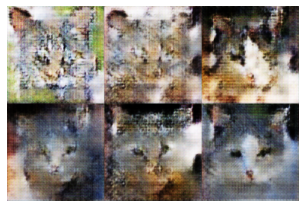

Epoch 10 | Discriminator loss: 0.7292098735187272 | Generator loss: 2.738113147871835



Epoch 11 | Discriminator loss: 0.6589476531573936 | Generator loss: 2.9954585170153507



Epoch 12 | Discriminator loss: 0.6581390900819372 | Generator loss: 3.0309664439525665



Epoch 13 | Discriminator loss: 0.603157081225307 | Generator loss: 3.1953917123516153



Epoch 14 | Discriminator loss: 0.5862994556364413 | Generator loss: 3.2052650181403073



Epoch 15 | Discriminator loss: 0.5805439913923048 | Generator loss: 3.0954627241036907



Epoch 16 | Discriminator loss: 0.5731002489861928 | Generator loss: 3.28068600780105



Epoch 17 | Discriminator loss: 0.5412708200060224 | Generator loss: 3.332939442177737



Epoch 18 | Discriminator loss: 0.5135086019162265 | Generator loss: 3.415745383741693



Epoch 19 | Discriminator loss: 0.5288119376322051 | Generator loss: 3.333871520315268


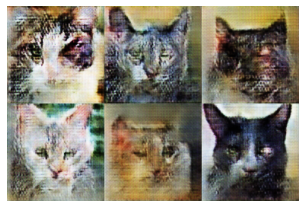

Epoch 20 | Discriminator loss: 0.49857962204151357 | Generator loss: 3.535827791098482



Epoch 21 | Discriminator loss: 0.47084094260899517 | Generator loss: 3.516317110439265



Epoch 22 | Discriminator loss: 0.4794955392236086 | Generator loss: 3.593542480690879



Epoch 23 | Discriminator loss: 0.4200102061528376 | Generator loss: 3.8733449159942057



Epoch 24 | Discriminator loss: 0.4474739865582474 | Generator loss: 3.659524297121889



Epoch 25 | Discriminator loss: 0.44460590375747866 | Generator loss: 3.7284520364696196



Epoch 26 | Discriminator loss: 0.40172301355057655 | Generator loss: 3.919161443847307



Epoch 27 | Discriminator loss: 0.3776347875301546 | Generator loss: 4.077027411101768



Epoch 28 | Discriminator loss: 0.40259324415779046 | Generator loss: 4.101757497058152



Epoch 29 | Discriminator loss: 0.3720631441949239 | Generator loss: 3.998314094099199


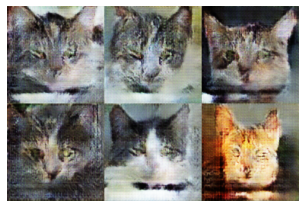

Epoch 30 | Discriminator loss: 0.3934029670457879 | Generator loss: 4.102263193785774



Epoch 31 | Discriminator loss: 0.37348206360588027 | Generator loss: 4.171665664600289



Epoch 32 | Discriminator loss: 0.33811675567066124 | Generator loss: 4.313899892087308



Epoch 33 | Discriminator loss: 0.31595561333952826 | Generator loss: 4.666588840832621



Epoch 34 | Discriminator loss: 0.3240275994400877 | Generator loss: 4.377483655623397



Epoch 35 | Discriminator loss: 0.32463144725424486 | Generator loss: 4.489393855011241



Epoch 36 | Discriminator loss: 0.34965609262164765 | Generator loss: 4.352561434233411



Epoch 37 | Discriminator loss: 0.33125203358440275 | Generator loss: 4.323814863512605



Epoch 38 | Discriminator loss: 0.3108106585215712 | Generator loss: 4.391165033723256



Epoch 39 | Discriminator loss: 0.29147593250544285 | Generator loss: 4.6428775530053965


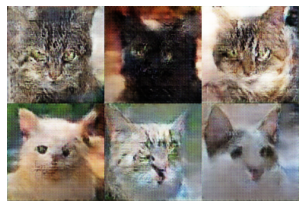

Epoch 40 | Discriminator loss: 0.28385606349407083 | Generator loss: 4.710307861429564



Epoch 41 | Discriminator loss: 0.29196242471182177 | Generator loss: 4.546705337368554



Epoch 42 | Discriminator loss: 0.3028364632003143 | Generator loss: 4.695372710872141



Epoch 43 | Discriminator loss: 0.31386627443909265 | Generator loss: 4.571520337915939



Epoch 44 | Discriminator loss: 0.2910824250698565 | Generator loss: 4.506042127098356



Epoch 45 | Discriminator loss: 0.24947760701284746 | Generator loss: 4.773390410456413



Epoch 46 | Discriminator loss: 0.26687297779553404 | Generator loss: 4.845440452050719



Epoch 47 | Discriminator loss: 0.2599374695180486 | Generator loss: 4.874479978998996



Epoch 48 | Discriminator loss: 0.27184690454975924 | Generator loss: 4.729797996164109



Epoch 49 | Discriminator loss: 0.25899994740067644 | Generator loss: 4.807231560812234


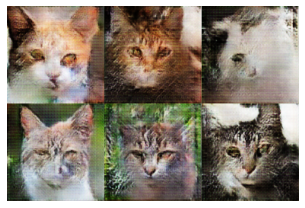

Epoch 50 | Discriminator loss: 0.26152188554601846 | Generator loss: 4.820310952778188


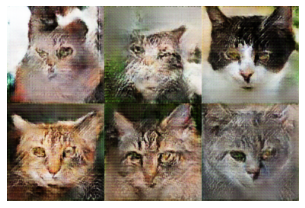

In [21]:
train_gan()

### Задание 3 (5 баллов)
Теперь посмотрим на другую модель: Variational Autoencoder. В отличии от GAN, в котором генератор пытается себя обмануть дискриминатор, а дискриминатор старается не быть обманутым, VAE решает задачу реконструкции элемента множества X с применением регуляризации в латентном пространстве. 

Полностью архитектура выглядит так:
![](https://github.com/SpirinEgor/HSE.machine_learning/blob/main/06.%20This%20Cat%20Does%20Not%20Exist/imgs/VAE.png?raw=1)

Из нее можно выделить две части: Encoder (по изображению возвращает mu и sigma) и Decoder (по случайному шуму восстанавливает изображение). На высоком уровне VAE можно представить так:

![](https://github.com/SpirinEgor/HSE.machine_learning/blob/main/06.%20This%20Cat%20Does%20Not%20Exist/imgs/VAE_highlevel.png?raw=1)

В данном задании вам необходимо реализовать полную архитектуру VAE.

#### Методы
* `__init__` - принимает на вход `img_size`, `downsamplings`, `latent_size`, `linear_hidden_size`, `down_channels` и `up_channels`. `img_size` - размер стороны входного изображения. `downsamplings` - количество downsampling (и upsampling) блоков. `latent_size` - размер латентного пространства, в котором в который будет закодирована картинка. `linear_hidden_size` количество нейронов на скрытом слое полносвязной сети в конце encoder'а. Для полносвязной сети decoder'а это число стоит умножить на 2. `down_channels` - количество каналов, в которое будет преобразовано трехцветное изображение перед применением `downsampling` блоков. `up_channels` - количество каналов, которое должно получиться после применения всех upsampling блоков.

* `forward` - принимает на вход `x`. Считает распределение $N(\mu, \sigma^2)$ и вектор $z \sim N(\mu, \sigma^2)$. Возвращает $x'$ - восстановленную из вектора $z$ картинку и $D_{KL}(N(\mu, \sigma^2), N(0, 1)) = 0.5 \cdot (\sigma^2 + \mu^2 - \log \sigma^2 - 1)$.

* `encode` - принимает на вход `x`. Возвращает вектор из распределения $N(\mu, \sigma^2)$.

* `decode` - принимает на вход `z`. Возвращает восстановленную по вектору картинку.


#### Если хочется улучшить качество
https://arxiv.org/pdf/1906.00446.pdf

In [ ]:
class VAE(nn.Module):
    def __init__(self, img_size=128, downsamplings=5, latent_size=512, linear_hidden_size=1024, down_channels=8, up_channels=16):
        super().__init__()
        self.encoder = None
        self.decoder = None
        
    def forward(self, x):
        return x_pred, kld
    
    def encode(self, x):
        return z
    
    def decode(self, z):
        return x_pred

In [ ]:
def train_vae():
    vae = VAE()
    vae.cuda()

    epochs = 201
    batch_size = 8
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    dataset = CatDataset(size=128)

    test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0

        if ep % 10 == 0:
            with torch.no_grad():
                z_1 = vae.encode(test_imgs_1.cuda())
                z_2 = vae.encode(test_imgs_2.cuda())
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.cuda()
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()

        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")

train_vae()